In [1]:
import logging
import numpy as np
from rdkit import Chem
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.optimize import linear_sum_assignment

from pandas import DataFrame
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import roc_auc_score
import pandas as pd
from numpy import mean
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:


def compute_gram_matrix(smiles_list1, smiles_list2, sigma=1, reg=1e-10, num_iters=1000):
    X1 = [Chem.MolFromSmiles(smiles) for smiles in smiles_list1]
    X2 = [Chem.MolFromSmiles(smiles) for smiles in smiles_list2]
    
    # Check for empty or NoneType molecules
    X1 = [x for x in X1 if x is not None]
    X2 = [x for x in X2 if x is not None]
    
    if len(X1) == 0 or len(X2) == 0:
        logging.error("One or more input SMILES lists are empty or contain invalid SMILES strings.")
        return None
    
    X1_feats = np.array([Chem.RDKFingerprint(mol) for mol in X1])
    print(np.array(X1).shape)
    print(X1_feats.shape)
    X2_feats = np.array([Chem.RDKFingerprint(mol) for mol in X2])
    print(X2_feats.shape)

    
    dist_matrix = pairwise_kernels(X1_feats, X2_feats)


    # use Sinkhorn-Knopp algorithm to compute kernel matrix
    n = dist_matrix.shape[0]
    m = dist_matrix.shape[1]
    a = np.ones(n) / n
    b = np.ones(m) / m
    K = np.exp(-dist_matrix / sigma)
    K /= K.sum()

    for i in range(num_iters):
        u = reg * np.log(a)
        v = reg * np.log(b)
        M = (-sigma * K + u.reshape(-1, 1) + v.reshape(1, -1)) / reg
        row_ind, col_ind = linear_sum_assignment(M)
        pi = np.zeros((n, m))
        pi[row_ind, col_ind] = 1
        a_new = pi.sum(axis=1)
        b_new = pi.sum(axis=0)
        if np.abs(a_new - a).max() < 1e-6 and np.abs(b_new - b).max() < 1e-6:
            break
        a = a_new
        b = b_new

    K = np.diag(a).dot(K).dot(np.diag(b))
    return K




# Kernel Computation

In [3]:
# haris new code

def compute_gram_matrix(smiles_list1, smiles_list2, sigma=1, reg=1e-10, num_iters=1000):
    X1 = [Chem.MolFromSmiles(smiles) for smiles in smiles_list1]
    X2 = [Chem.MolFromSmiles(smiles) for smiles in smiles_list2]
    
    # Check for empty or NoneType molecules
    X1 = [x for x in X1 if x is not None]
    X2 = [x for x in X2 if x is not None]
    
    if len(X1) == 0 or len(X2) == 0:
        logging.error("One or more input SMILES lists are empty or contain invalid SMILES strings.")
        return None
    
    X1_feats = np.array([Chem.RDKFingerprint(mol) for mol in X1])
    X2_feats = np.array([Chem.RDKFingerprint(mol) for mol in X2])

    
    dist_matrix = pairwise_kernels(X1_feats, X2_feats)


    # use Sinkhorn-Knopp algorithm to compute kernel matrix
    n = dist_matrix.shape[0]
    m = dist_matrix.shape[1]
    a = np.ones(n) / n
    b = np.ones(m) / m
    #K = np.exp(-dist_matrix / sigma)
    K = dist_matrix / sigma
    K /= K.sum()

    for i in range(num_iters):
        u = reg * np.log(a)
        v = reg * np.log(b)
        M = (-sigma * K + u.reshape(-1, 1) + v.reshape(1, -1)) / reg
        row_ind, col_ind = linear_sum_assignment(M)
        pi = np.zeros((n, m))
        pi[row_ind, col_ind] = 1
        a_new = pi.sum(axis=1)
        b_new = pi.sum(axis=0)
        if np.abs(a_new - a).max() < 1e-6 and np.abs(b_new - b).max() < 1e-6:
            break
        a = a_new
        b = b_new

    K = np.diag(a).dot(K).dot(np.diag(b))
    return K

In [4]:
sm_1 = np.load("E:/RA/SMILES_Morgan_kmers_EMNLP/Dataset/SMILE_Strings_6897_seq.npy")

# sm_1 = ["CCNC(C)C(NC)c1ccccc1","CONC(=O)c1cncnc1","CCNC1CCCN(Cc2ccsc2)C1"]
sm_2 = sm_1[:]

X1 = [Chem.MolFromSmiles(smiles) for smiles in sm_1]
X2 = [Chem.MolFromSmiles(smiles) for smiles in sm_2]

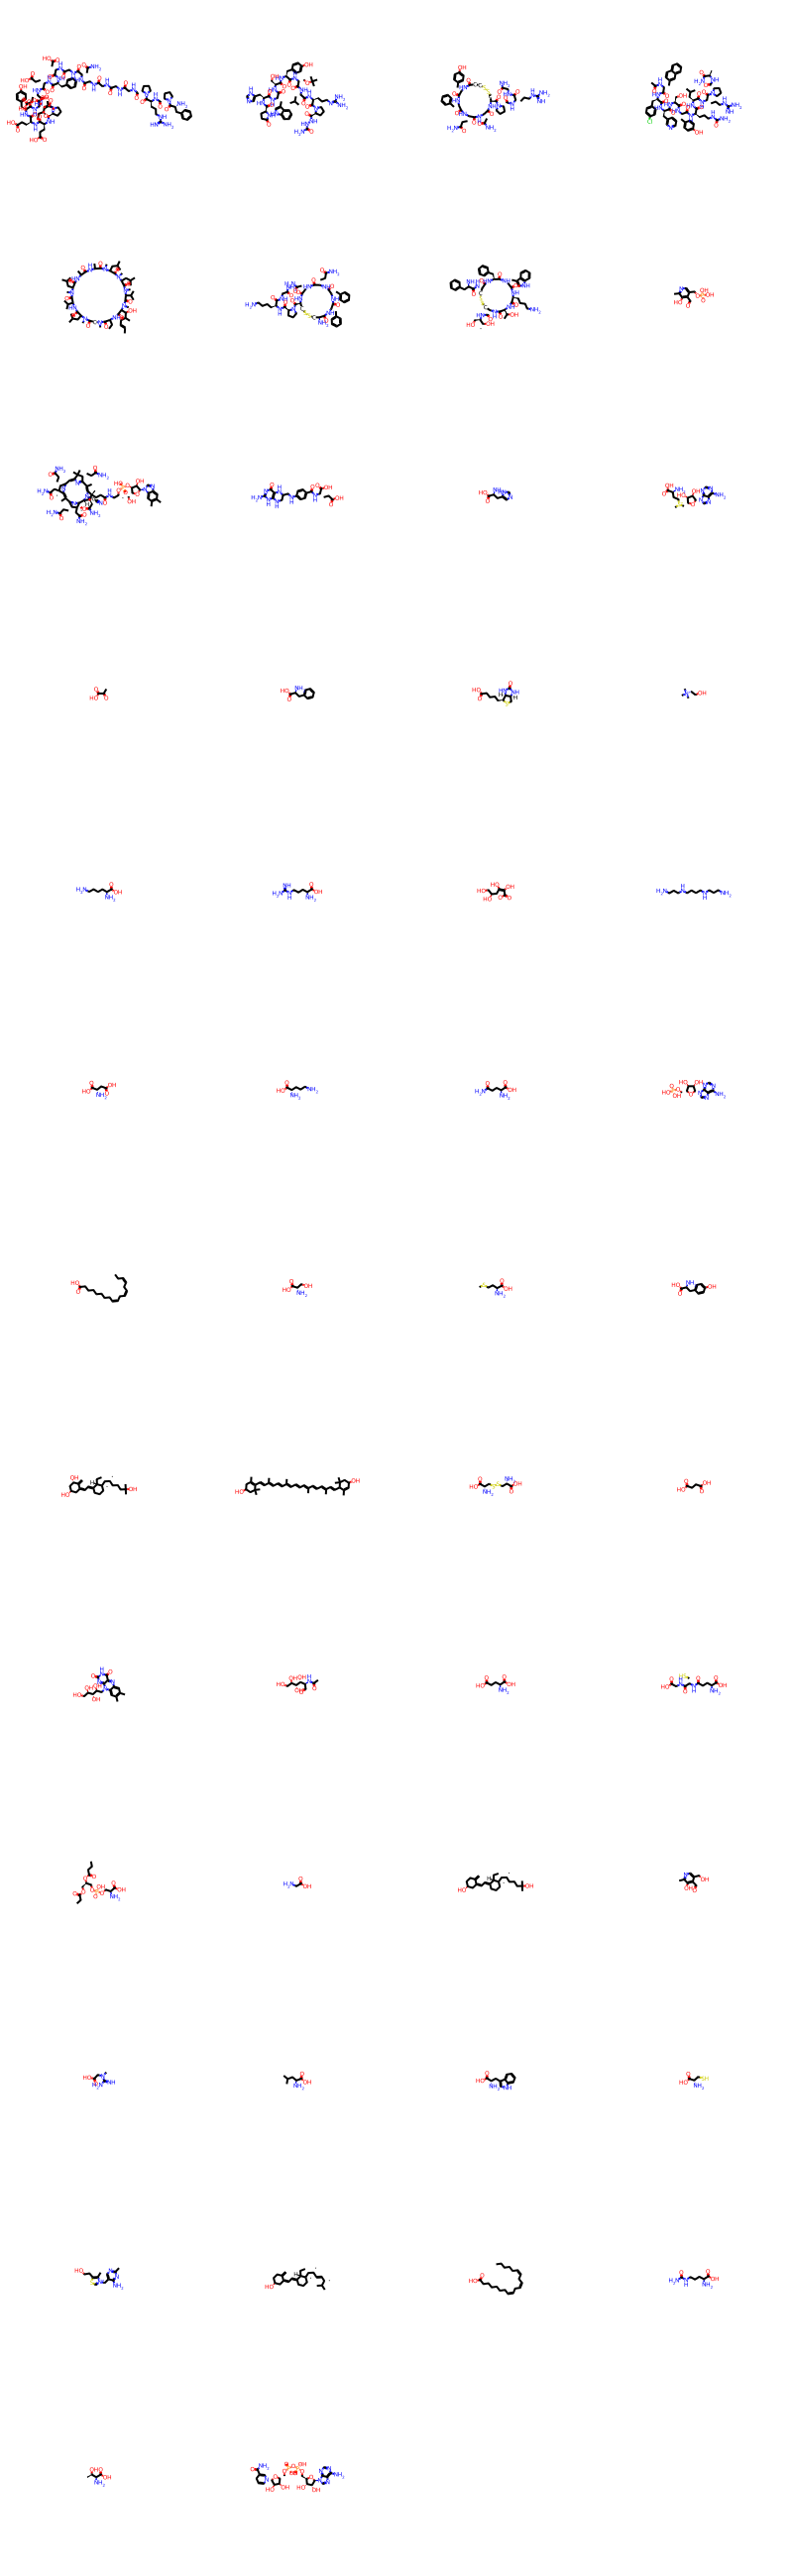

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw
# Visualize the molecules
# Visualize the molecules
img = Draw.MolsToGridImage(X1, molsPerRow=4)
display(img)

In [10]:
# pip install rdkit networkx
import networkx as nx

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)

    # Create an empty graph
    graph = nx.Graph()

    # Iterate over atoms and add them as nodes to the graph
    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(), atomic_number=atom.GetAtomicNum(), symbol=atom.GetSymbol())

    # Iterate over bonds and add them as edges to the graph
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtom().GetIdx()
        end_idx = bond.GetEndAtom().GetIdx()
        graph.add_edge(start_idx, end_idx, bond_type=bond.GetBondTypeAsDouble())

    return graph

graphs = [smiles_to_graph(smiles) for smiles in sm_1]


In [11]:
graphs

 ...]

In [14]:
graph = graphs[0]
nodes = list(graph.nodes(data=True))
edges = list(graph.edges(data=True))

edges

[(0, 1, {'bond_type': 1.0}),
 (1, 2, {'bond_type': 1.0}),
 (2, 3, {'bond_type': 1.0}),
 (2, 4, {'bond_type': 1.0}),
 (4, 5, {'bond_type': 1.0}),
 (4, 107, {'bond_type': 1.0}),
 (5, 6, {'bond_type': 1.0}),
 (6, 7, {'bond_type': 2.0}),
 (6, 8, {'bond_type': 1.0}),
 (8, 9, {'bond_type': 1.0}),
 (8, 14, {'bond_type': 1.0}),
 (9, 10, {'bond_type': 1.0}),
 (10, 11, {'bond_type': 1.0}),
 (11, 12, {'bond_type': 1.0}),
 (11, 13, {'bond_type': 2.0}),
 (14, 15, {'bond_type': 1.0}),
 (15, 16, {'bond_type': 2.0}),
 (15, 17, {'bond_type': 1.0}),
 (17, 18, {'bond_type': 1.0}),
 (17, 23, {'bond_type': 1.0}),
 (18, 19, {'bond_type': 1.0}),
 (19, 20, {'bond_type': 1.0}),
 (20, 21, {'bond_type': 1.0}),
 (20, 22, {'bond_type': 2.0}),
 (23, 24, {'bond_type': 1.0}),
 (24, 25, {'bond_type': 2.0}),
 (24, 26, {'bond_type': 1.0}),
 (26, 27, {'bond_type': 1.0}),
 (26, 34, {'bond_type': 1.0}),
 (27, 28, {'bond_type': 1.0}),
 (28, 29, {'bond_type': 1.5}),
 (28, 33, {'bond_type': 1.5}),
 (29, 30, {'bond_type': 1.5}

In [4]:
sm_1 = np.load("E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/SMILE_Strings_6897_seq.npy")

# sm_1 = ["CCNC(C)C(NC)c1ccccc1","CONC(=O)c1cncnc1","CCNC1CCCN(Cc2ccsc2)C1"]
sm_2 = sm_1[:]
kernel_matrix = compute_gram_matrix(sm_1,sm_2)

In [14]:
sm_1[6]

'C[C@@H](O)[C@@H](CO)NC(=O)[C@@H]1CSSC[C@H](NC(=O)[C@H](N)CC2=CC=CC=C2)C(=O)N[C@@H](CC2=CC=CC=C2)C(=O)N[C@H](CC2=CNC3=C2C=CC=C3)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C(C)O)C(=O)N1'

In [5]:
kernel_matrix.shape

(6897, 6897)

In [6]:
from sklearn.decomposition import KernelPCA
# Perform kernel PCA with your customized kernel
n_components = 1000
kpca = KernelPCA(n_components=n_components, kernel='precomputed')
X_kpca = kpca.fit_transform(kernel_matrix)

In [7]:
np.save("E:/RA/SMILES_String_Kernel/Data/SMILES_String_Kernel_6897_x_1000.npy",X_kpca)

# Data Statistics

In [52]:
attribute_data = np.load("E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/drug_subcategories_6897_attributes.npy")
solubility_data = np.load("E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/SMILE_Strings_6897_attributes_solubility_ALOGPS.npy")
drug_data = np.load("E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/drug_names_6897_attributes.npy")


reduced_labels = ["others","Barbiturate [EPC]","Amide Local Anesthetic [EPC]",
                 "Non-Standardized Plant Allergenic Extract [EPC]","Sulfonylurea [EPC]",
                 "Corticosteroid [EPC]","Nonsteroidal Anti-inflammatory Drug [EPC]",
                 "Nucleoside Metabolic Inhibitor [EPC]","Nitroimidazole Antimicrobial [EPC]",
                 "Muscle Relaxant [EPC]"]

one = []
two = []
three = []
four = []
five = []
six = []
seven = []
eight = []
nine = []
ten = []
ten_attr = []
ten_attr_reg = []

data_array = sm_1[:]
attr_array = attribute_data[:]

for i in range(len(data_array)):
    if attr_array[i]==reduced_labels[0]:
        one.append(data_array[i])
    if attr_array[i]==reduced_labels[1]:
        two.append(data_array[i])
    elif attr_array[i]==reduced_labels[2]:
        three.append(data_array[i])
    elif attr_array[i]==reduced_labels[3]:
        four.append(data_array[i])
    elif attr_array[i]==reduced_labels[4]:
        five.append(data_array[i])
    elif attr_array[i]==reduced_labels[5]:
        six.append(data_array[i])
    elif attr_array[i]==reduced_labels[6]:
        seven.append(data_array[i])
    elif attr_array[i]==reduced_labels[7]:
        eight.append(data_array[i])
    elif attr_array[i]==reduced_labels[8]:
        nine.append(data_array[i])
    elif attr_array[i]==reduced_labels[9]:
        ten.append(data_array[i])
        ten_attr.append(attr_array[i])
        ten_attr_reg.append(solubility_data[i])

len(one), len(two),len(three),len(four),len(five),len(six),len(seven),len(eight),len(nine),len(ten)




(6299, 54, 53, 29, 17, 16, 15, 11, 10, 10)

In [47]:
min_val = 100
max_val = 0
avg_val_cnt = 0

dtt = ten[:]
for i in range(len(dtt)):
    if len(dtt[i])<min_val:
        min_val = len(dtt[i])
    elif len(dtt[i])>max_val:
        max_val = len(dtt[i])
    avg_val_cnt = avg_val_cnt + len(dtt[i])

min_val, max_val, avg_val_cnt/len(dtt)

(9, 82, 49.8)

In [39]:

# # Get unique labels and their counts
# unique_labels, label_counts = np.unique(attribute_data, return_counts=True)

# # Print label distribution
# for label, count in zip(unique_labels, label_counts):
#     print("Label {}: {} instances".format(label, count))


In [53]:
# ten[3],ten_attr[3],ten_attr_reg[3]
id_val = 100

sm_1[id_val], drug_data[id_val], attribute_data[id_val],solubility_data[id_val]


('COC1=C(C=C(C=C1)C1=CC2=C(C=C1)C=C(C=C2)C(O)=O)C12CC3CC(CC(C3)C1)C2',
 'Adapalene',
 'Retinoid [EPC]',
 4.01e-06)

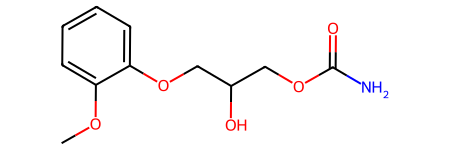

In [44]:
# smile_strings = "C[S+](CC[C@H](N)C(O)=O)C[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=NC2=C(N)N=CN=C12"
smile_strings = ten[3]
# Convert SMILES to RDKit molecule
mol = Chem.MolFromSmiles(smile_strings)
mol

# Regression Analysis

In [36]:
X = X_kpca[:]
y = np.load("E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/SMILE_Strings_6897_attributes_solubility_ALOGPS.npy")


In [37]:
y

array([0.0464, 0.0283, 0.11  , ..., 0.361 , 0.0044, 0.0097])

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np

# # Assume that frequency_vector contains the k-mer spectrum embedding for SMILES strings, and smile_strings_label contains the solubility label.
# X = np.array(X_kpca)
# y = np.array(smile_strings_label)

# Split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models.
linear_reg = LinearRegression()
ridge_reg = Ridge(alpha=1)
lasso_reg = Lasso(alpha=0.1)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
gb_reg = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the models.
linear_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
rf_reg.fit(X_train, y_train)
gb_reg.fit(X_train, y_train)

# Make predictions on the test set.
y_pred_linear_reg = linear_reg.predict(X_test)
y_pred_ridge_reg = ridge_reg.predict(X_test)
y_pred_lasso_reg = lasso_reg.predict(X_test)
y_pred_rf_reg = rf_reg.predict(X_test)
y_pred_gb_reg = gb_reg.predict(X_test)




In [39]:
# Compute evaluation metrics for each model.
linear_reg_mae = mean_absolute_error(y_test, y_pred_linear_reg)
ridge_reg_mae = mean_absolute_error(y_test, y_pred_ridge_reg)
lasso_reg_mae = mean_absolute_error(y_test, y_pred_lasso_reg)
rf_reg_mae = mean_absolute_error(y_test, y_pred_rf_reg)
gb_reg_mae = mean_absolute_error(y_test, y_pred_gb_reg)

linear_reg_mse = mean_squared_error(y_test, y_pred_linear_reg)
ridge_reg_mse = mean_squared_error(y_test, y_pred_ridge_reg)
lasso_reg_mse = mean_squared_error(y_test, y_pred_lasso_reg)
rf_reg_mse = mean_squared_error(y_test, y_pred_rf_reg)
gb_reg_mse = mean_squared_error(y_test, y_pred_gb_reg)

linear_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_linear_reg))
ridge_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge_reg))
lasso_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso_reg))
rf_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_reg))
gb_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb_reg))

linear_reg_r2 = r2_score(y_test, y_pred_linear_reg)
ridge_reg_r2 = r2_score(y_test, y_pred_ridge_reg)
lasso_reg_r2 = r2_score(y_test, y_pred_lasso_reg)
rf_reg_r2 = r2_score(y_test, y_pred_rf_reg)
gb_reg_r2 = r2_score(y_test, y_pred_gb_reg)

linear_reg_evs = explained_variance_score(y_test, y_pred_linear_reg)
ridge_reg_evs = explained_variance_score(y_test, y_pred_ridge_reg)
lasso_reg_evs = explained_variance_score(y_test, y_pred_lasso_reg)
rf_reg_evs = explained_variance_score(y_test, y_pred_rf_reg)
gb_reg_evs = explained_variance_score(y_test, y_pred_gb_reg)

# Print the evaluation metrics for each model.
print("Linear Regression:")
print("MAE:", linear_reg_mae)
print("MSE:", linear_reg_mse)
print("RMSE:", linear_reg_rmse)
print("R^2:", linear_reg_r2)
print("EVS:", linear_reg_evs)

print("Ridge Regression:")
print("MAE:", ridge_reg_mae)
print("MSE:", ridge_reg_mse)
print("RMSE:", ridge_reg_rmse)
print("R^2:", ridge_reg_r2)
print("EVS:", ridge_reg_evs)

print("Lasso Regression:")
print("MAE:", lasso_reg_mae)
print("MSE:", lasso_reg_mse)
print("RMSE:", lasso_reg_rmse)
print("R^2:", lasso_reg_r2)
print("EVS:", lasso_reg_evs)

print("Random Forest Regression:")
print("MAE:", rf_reg_mae)
print("MSE:", rf_reg_mse)
print("RMSE:", rf_reg_rmse)
print("R^2:", rf_reg_r2)
print("EVS:", rf_reg_evs)

print("Gradient Boosting Regression:")
print("MAE:", gb_reg_mae)
print("MSE:", gb_reg_mse)
print("RMSE:", gb_reg_rmse)
print("R^2:", gb_reg_r2)
print("EVS:", gb_reg_evs)


Linear Regression:
MAE: 68.15630717559635
MSE: 26155.267327588183
RMSE: 161.7259018450297
R^2: -0.546644456732996
EVS: -0.5427025987088885
Ridge Regression:
MAE: 50.53118282830021
MSE: 16912.557672669434
RMSE: 130.04828977218207
R^2: -9.352785396754548e-05
EVS: 0.00014289641632936334
Lasso Regression:
MAE: 50.53725266989145
MSE: 16914.974883552866
RMSE: 130.05758295290923
R^2: -0.00023646525035458943
EVS: 0.0
Random Forest Regression:
MAE: 31.3601560875841
MSE: 7739.5454520043395
RMSE: 87.97468642742831
R^2: 0.5423359692313501
EVS: 0.5445100061237667
Gradient Boosting Regression:
MAE: 30.666268085205246
MSE: 7730.648606169963
RMSE: 87.92410708201683
R^2: 0.5428620681283639
EVS: 0.5428908649600146


# Classification

In [6]:
X = X_kpca[:]
attribute_data = np.load("E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/drug_subcategories_6897_attributes.npy")


attr_new = []
for i in range(len(attribute_data)):
    aa = str(attribute_data[i]).replace("[","")
    aa_1 = aa.replace("]","")
    aa_2 = aa_1.replace("\'","")
    attr_new.append(aa_2)

unique_hst = list(np.unique(attr_new))

int_hosts = []
for ind_unique in range(len(attr_new)):
    variant_tmp = attr_new[ind_unique]
    ind_tmp = unique_hst.index(variant_tmp)
    int_hosts.append(ind_tmp)
    
print("Attribute data preprocessing Done")

Attribute data preprocessing Done


In [7]:
X.shape

(6897, 1000)

In [8]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc
    
    
    check = pd.DataFrame(roc_auc_dict.items())
    return mean(check)

def svm_fun_kernel(X_train,y_train,X_test,y_test,kernel_mat):

    start = timeit.default_timer()
#     stop = timeit.default_timer()
#     print("NB Time : ", stop - start) 
#     clf = svm.SVC()
    clf = svm.SVC(kernel=kernel_mat)
    
    #Train the model using the training sets
    clf.fit(kernel_mat, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    stop = timeit.default_timer()
    time_new = stop - start
    
    svm_acc = metrics.accuracy_score(y_test, y_pred)
#     print("SVM Accuracy:",svm_acc)
    
    svm_prec = metrics.precision_score(y_test, y_pred,average='weighted')
#     print("SVM Precision:",svm_prec)
    
    svm_recall = metrics.recall_score(y_test, y_pred,average='weighted')
#     print("SVM Recall:",svm_recall)

    svm_f1_weighted = metrics.f1_score(y_test, y_pred,average='weighted')
#     print("SVM F1 Weighted:",svm_f1_weighted)
    
    svm_f1_macro = metrics.f1_score(y_test, y_pred,average='macro')
#     print("SVM F1 macro:",svm_f1_macro)
    
    svm_f1_micro = metrics.f1_score(y_test, y_pred,average='micro')
#     print("SVM F1 micro:",svm_f1_micro)
    
    confuse = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix SVM : \n", confuse)
    #print("SVM Kernel Class Wise Accuracy : ",confuse.diagonal()/confuse.sum(axis=1))
    ######################## Compute ROC curve and ROC area for each class ################
    y_prob = y_pred
    macro_roc_auc_ovo = roc_auc_score_multiclass(y_test, y_prob, average='macro')
#    print(macro_roc_auc_ovo[1])
    check = [svm_acc,svm_prec,svm_recall,svm_f1_weighted,svm_f1_macro,macro_roc_auc_ovo[1],time_new]
    return(check)
    
# In[5]
##########################  SVM Classifier  ################################
def svm_fun(X_train,y_train,X_test,y_test):

    #scaler = RobustScaler()
    X_train = preprocessing.scale(X_train)  
    X_test = preprocessing.scale(X_test)  
    
    
    start = timeit.default_timer()
    
    
    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    stop = timeit.default_timer()
    time_new = stop - start
#     print("NB Time : ", stop - start) 
    
    svm_acc = metrics.accuracy_score(y_test, y_pred)
#     print("SVM Accuracy:",svm_acc)
    
    svm_prec = metrics.precision_score(y_test, y_pred,average='weighted')
#     print("SVM Precision:",svm_prec)
    
    svm_recall = metrics.recall_score(y_test, y_pred,average='weighted')
#     print("SVM Recall:",svm_recall)

    svm_f1_weighted = metrics.f1_score(y_test, y_pred,average='weighted')
#     print("SVM F1 Weighted:",svm_f1_weighted)
    
    svm_f1_macro = metrics.f1_score(y_test, y_pred,average='macro')
#     print("SVM F1 macro:",svm_f1_macro)
    
    svm_f1_micro = metrics.f1_score(y_test, y_pred,average='micro')
#     print("SVM F1 micro:",svm_f1_micro)
    
    confuse = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix SVM : \n", confuse)
    #print("SVM Class Wise Accuracy : ",confuse.diagonal()/confuse.sum(axis=1))
    ######################## Compute ROC curve and ROC area for each class ################
    y_prob = y_pred
    macro_roc_auc_ovo = roc_auc_score_multiclass(y_test, y_prob, average='macro')
#    print(macro_roc_auc_ovo[1])
    check = [svm_acc,svm_prec,svm_recall,svm_f1_weighted,svm_f1_macro,macro_roc_auc_ovo[1],time_new]
    return(check)
    


# In[5]
##########################  NB Classifier  ################################
def gaus_nb_fun(X_train,y_train,X_test,y_test):
    start = timeit.default_timer()
#     stop = timeit.default_timer()
#     print("NB Time : ", stop - start) 
    
    
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    
    stop = timeit.default_timer()
    time_new = stop - start


    NB_acc = metrics.accuracy_score(y_test, y_pred)
#     print("Gaussian NB Accuracy:",NB_acc)

    NB_prec = metrics.precision_score(y_test, y_pred,average='weighted')
#     print("Gaussian NB Precision:",NB_prec)
    
    NB_recall = metrics.recall_score(y_test, y_pred,average='weighted')
#     print("Gaussian NB Recall:",NB_recall)
    
    NB_f1_weighted = metrics.f1_score(y_test, y_pred,average='weighted')
#     print("Gaussian NB F1 weighted:",NB_f1_weighted)
    
    NB_f1_macro = metrics.f1_score(y_test, y_pred,average='macro')
#     print("Gaussian NB F1 macro:",NB_f1_macro)
    
    NB_f1_micro = metrics.f1_score(y_test, y_pred,average='micro')
#     print("Gaussian NB F1 micro:",NB_f1_micro)
    
    confuse = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix NB : \n", confuse)
    #print("NB Class Wise Accuracy : ",confuse.diagonal()/confuse.sum(axis=1))
    ######################## Compute ROC curve and ROC area for each class ################
    y_prob = y_pred
    macro_roc_auc_ovo = roc_auc_score_multiclass(y_test, y_prob, average='macro')
    check = [NB_acc,NB_prec,NB_recall,NB_f1_weighted,NB_f1_macro,macro_roc_auc_ovo[1],time_new]
    return(check)

# In[5]
##########################  MLP Classifier  ################################
def mlp_fun(X_train,y_train,X_test,y_test):
    start = timeit.default_timer()
#     stop = timeit.default_timer()
#     print("NB Time : ", stop - start) 
    
    
    # Feature scaling
    scaler = StandardScaler()  
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)  
    X_test_2 = scaler.transform(X_test)


    # Finally for the MLP- Multilayer Perceptron
    mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)  
    mlp.fit(X_train, y_train)


    y_pred = mlp.predict(X_test_2)
    
    stop = timeit.default_timer()
    time_new = stop - start
    
    MLP_acc = metrics.accuracy_score(y_test, y_pred)
#     print("MLP Accuracy:",MLP_acc)
    
    MLP_prec = metrics.precision_score(y_test, y_pred,average='weighted')
#     print("MLP Precision:",MLP_prec)
    
    MLP_recall = metrics.recall_score(y_test, y_pred,average='weighted')
#     print("MLP Recall:",MLP_recall)
    
    MLP_f1_weighted = metrics.f1_score(y_test, y_pred,average='weighted')
#     print("MLP F1:",MLP_f1_weighted)
    
    MLP_f1_macro = metrics.f1_score(y_test, y_pred,average='macro')
#     print("MLP F1:",MLP_f1_macro)
    
    MLP_f1_micro = metrics.f1_score(y_test, y_pred,average='micro')
#     print("MLP F1:",MLP_f1_micro)
    
    confuse = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix MLP : \n", confuse)
    #print("MLP Class Wise Accuracy : ",confuse.diagonal()/confuse.sum(axis=1))
    ######################## Compute ROC curve and ROC area for each class ################
    y_prob = y_pred
    macro_roc_auc_ovo = roc_auc_score_multiclass(y_test, y_prob, average='macro')
    
    check = [MLP_acc,MLP_prec,MLP_recall,MLP_f1_weighted,MLP_f1_macro,macro_roc_auc_ovo[1],time_new]
    return(check)

# In[5]
##########################  knn Classifier  ################################
def knn_fun(X_train,y_train,X_test,y_test):
    start = timeit.default_timer()
#     stop = timeit.default_timer()
#     print("NB Time : ", stop - start) 
    
    
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    
    stop = timeit.default_timer()
    time_new = stop - start

    knn_acc = metrics.accuracy_score(y_test, y_pred)
#     print("Knn Accuracy:",knn_acc)
    
    knn_prec = metrics.precision_score(y_test, y_pred,average='weighted')
#     print("Knn Precision:",knn_prec)
    
    knn_recall = metrics.recall_score(y_test, y_pred,average='weighted')
#     print("Knn Recall:",knn_recall)
    
    knn_f1_weighted = metrics.f1_score(y_test, y_pred,average='weighted')
#     print("Knn F1 weighted:",knn_f1_weighted)
    
    knn_f1_macro = metrics.f1_score(y_test, y_pred,average='macro')
#     print("Knn F1 macro:",knn_f1_macro)
    
    knn_f1_micro = metrics.f1_score(y_test, y_pred,average='micro')
#     print("Knn F1 micro:",knn_f1_micro)
    
    confuse = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix KNN : \n", confuse)
    #print("KNN Class Wise Accuracy : ",confuse.diagonal()/confuse.sum(axis=1))
    ######################## Compute ROC curve and ROC area for each class ################
    y_prob = y_pred
    macro_roc_auc_ovo = roc_auc_score_multiclass(y_test, y_prob, average='macro')
    
    check = [knn_acc,knn_prec,knn_recall,knn_f1_weighted,knn_f1_macro,macro_roc_auc_ovo[1],time_new]
    return(check)

# In[5]
##########################  Random Forest Classifier  ################################
def rf_fun(X_train,y_train,X_test,y_test):
    start = timeit.default_timer()
#     stop = timeit.default_timer()
#     print("NB Time : ", stop - start) 
    
    
    # Import the model we are using
    from sklearn.ensemble import RandomForestClassifier
    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators = 100)
    # Train the model on training data
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    stop = timeit.default_timer()
    time_new = stop - start

    fr_acc = metrics.accuracy_score(y_test, y_pred)
#     print("Random Forest Accuracy:",fr_acc)
    
    fr_prec = metrics.precision_score(y_test, y_pred,average='weighted')
#     print("Random Forest Precision:",fr_prec)
    
    fr_recall = metrics.recall_score(y_test, y_pred,average='weighted')
#     print("Random Forest Recall:",fr_recall)
    
    fr_f1_weighted = metrics.f1_score(y_test, y_pred,average='weighted')
#     print("Random Forest F1 weighted:",fr_f1_weighted)
    
    fr_f1_macro = metrics.f1_score(y_test, y_pred,average='macro')
#     print("Random Forest F1 macro:",fr_f1_macro)
    
    fr_f1_micro = metrics.f1_score(y_test, y_pred,average='micro')
#     print("Random Forest F1 micro:",fr_f1_micro)
    
    confuse = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix RF : \n", confuse)
    #print("RF Class Wise Accuracy : ",confuse.diagonal()/confuse.sum(axis=1))
    ######################## Compute ROC curve and ROC area for each class ################
    y_prob = y_pred
    macro_roc_auc_ovo = roc_auc_score_multiclass(y_test, y_prob, average='macro')
    
    check = [fr_acc,fr_prec,fr_recall,fr_f1_weighted,fr_f1_macro,macro_roc_auc_ovo[1],time_new]
    return(check)

# In[5]
    ##########################  Logistic Regression Classifier  ################################
def lr_fun(X_train,y_train,X_test,y_test):
    start = timeit.default_timer()
#     stop = timeit.default_timer()
#     print("NB Time : ", stop - start) 
    

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    stop = timeit.default_timer()
    time_new = stop - start

    LR_acc = metrics.accuracy_score(y_test, y_pred)
#     print("Logistic Regression Accuracy:",LR_acc)
    
    LR_prec = metrics.precision_score(y_test, y_pred,average='weighted')
#     print("Logistic Regression Precision:",LR_prec)
    
    LR_recall = metrics.recall_score(y_test, y_pred,average='weighted')
#     print("Logistic Regression Recall:",LR_recall)
    
    LR_f1_weighted = metrics.f1_score(y_test, y_pred,average='weighted')
#     print("Logistic Regression F1 weighted:",LR_f1_weighted)
    
    LR_f1_macro = metrics.f1_score(y_test, y_pred,average='macro')
#     print("Logistic Regression F1 macro:",LR_f1_macro)
    
    LR_f1_micro = metrics.f1_score(y_test, y_pred,average='micro')
#     print("Logistic Regression F1 micro:",LR_f1_micro)
    
    confuse = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix LR : \n", confuse)
    #print("LR Class Wise Accuracy : ",confuse.diagonal()/confuse.sum(axis=1))
    ######################## Compute ROC curve and ROC area for each class ################
    y_prob = y_pred
    macro_roc_auc_ovo = roc_auc_score_multiclass(y_test, y_prob, average='macro')
    
    check = [LR_acc,LR_prec,LR_recall,LR_f1_weighted,LR_f1_macro,macro_roc_auc_ovo[1],time_new]
    return(check)


def fun_decision_tree(X_train,y_train,X_test,y_test):
    from sklearn import tree
    
    start = timeit.default_timer()
#     stop = timeit.default_timer()
#     print("NB Time : ", stop - start) 
    
    clf = tree.DecisionTreeClassifier()    
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    stop = timeit.default_timer()
    time_new = stop - start
    
    dt_acc = metrics.accuracy_score(y_test, y_pred)
#     print("Logistic Regression Accuracy:",LR_acc)
    
    dt_prec = metrics.precision_score(y_test, y_pred,average='weighted')
#     print("Logistic Regression Precision:",LR_prec)
    
    dt_recall = metrics.recall_score(y_test, y_pred,average='weighted')
#     print("Logistic Regression Recall:",LR_recall)
    
    dt_f1_weighted = metrics.f1_score(y_test, y_pred,average='weighted')
#     print("Logistic Regression F1 weighted:",LR_f1_weighted)
    
    dt_f1_macro = metrics.f1_score(y_test, y_pred,average='macro')
#     print("Logistic Regression F1 macro:",LR_f1_macro)
    
    dt_f1_micro = metrics.f1_score(y_test, y_pred,average='micro')
#     print("Logistic Regression F1 micro:",LR_f1_micro)
    
    confuse = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix DT : \n", confuse)
    #print("DT Class Wise Accuracy : ",confuse.diagonal()/confuse.sum(axis=1))
    ######################## Compute ROC curve and ROC area for each class ################
    y_prob = y_pred
    macro_roc_auc_ovo = roc_auc_score_multiclass(y_test, y_prob, average='macro')
    
    check = [dt_acc,dt_prec,dt_recall,dt_f1_weighted,dt_f1_macro,macro_roc_auc_ovo[1],time_new]
    return(check)

In [9]:
import timeit

# X = np.array(seq_data)
y = np.array(int_hosts)

# print("Accuracy   Precision   Recall   F1 (weighted)   F1 (Macro)   F1 (Micro)   ROC AUC")
svm_table = []
gauu_nb_table = []
mlp_table = []
knn_table = []
rf_table = []
lr_table = []
dt_table = []

total_splits = 5

from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
sss = ShuffleSplit(n_splits=total_splits, test_size=0.3)
sss.get_n_splits(X, y)

for splits_ind in range(total_splits):
    train_index, test_index = next(sss.split(X, y)) 

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    start = timeit.default_timer()
    gauu_nb_return = gaus_nb_fun(X_train,y_train,X_test,y_test)
    stop = timeit.default_timer()
    print("NB Time : ", stop - start) 

    start = timeit.default_timer()
    mlp_return = mlp_fun(X_train,y_train,X_test,y_test)
    stop = timeit.default_timer()
    print("MLP Time : ", stop - start) 

    start = timeit.default_timer()
    knn_return = knn_fun(X_train,y_train,X_test,y_test)
    stop = timeit.default_timer()
    print("KNN Time : ", stop - start) 

    start = timeit.default_timer()
    rf_return = rf_fun(X_train,y_train,X_test,y_test)
    stop = timeit.default_timer()
    print("RF Time : ", stop - start) 

    start = timeit.default_timer()
    lr_return = lr_fun(X_train,y_train,X_test,y_test)
    stop = timeit.default_timer()
    print("LR Time : ", stop - start) 

    start = timeit.default_timer()
    dt_return = fun_decision_tree(X_train,y_train,X_test,y_test)
    stop = timeit.default_timer()
    print("DT Time : ", stop - start) 

    start = timeit.default_timer()
    svm_return = svm_fun(X_train,y_train,X_test,y_test)
    stop = timeit.default_timer()
    print("SVM Time : ", stop - start) 

    gauu_nb_table.append(gauu_nb_return)
    mlp_table.append(mlp_return)
    knn_table.append(knn_return)
    rf_table.append(rf_return)
    lr_table.append(lr_return)
    dt_table.append(dt_return)
    svm_table.append(svm_return)

    svm_table_final = DataFrame(svm_table, columns=["Accuracy","Precision","Recall",
                                                    "F1 (weighted)","F1 (Macro)","ROC AUC","Runtime"])
    gauu_nb_table_final = DataFrame(gauu_nb_table, columns=["Accuracy","Precision","Recall",
                                                    "F1 (weighted)","F1 (Macro)","ROC AUC","Runtime"])
    mlp_table_final = DataFrame(mlp_table, columns=["Accuracy","Precision","Recall",
                                                    "F1 (weighted)","F1 (Macro)","ROC AUC","Runtime"])
    knn_table_final = DataFrame(knn_table, columns=["Accuracy","Precision","Recall",
                                                    "F1 (weighted)","F1 (Macro)","ROC AUC","Runtime"])
    rf_table_final = DataFrame(rf_table, columns=["Accuracy","Precision","Recall",
                                                    "F1 (weighted)","F1 (Macro)","ROC AUC","Runtime"])
    lr_table_final = DataFrame(lr_table, columns=["Accuracy","Precision","Recall",
                                                    "F1 (weighted)","F1 (Macro)","ROC AUC","Runtime"])

    dt_table_final = DataFrame(dt_table, columns=["Accuracy","Precision","Recall",
                                                    "F1 (weighted)","F1 (Macro)","ROC AUC","Runtime"])


C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


NB Time :  7.357439599999452


C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MLP Time :  66.45148549999976


C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


KNN Time :  1.61799130000054


C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


RF Time :  43.89150999999947


C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


LR Time :  53.075332100000196


C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


DT Time :  41.95110130000012


C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Time :  126.06187600000067


C:\Users\sali85\Anaconda3\envs\New_Env_2\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [1]:
#taking average of all k-fold performance values
final_mean_mat = []

final_mean_mat.append(np.transpose((list(svm_table_final.mean()))))
final_mean_mat.append(np.transpose((list(gauu_nb_table_final.mean()))))
final_mean_mat.append(np.transpose((list(mlp_table_final.mean()))))
final_mean_mat.append(np.transpose((list(knn_table_final.mean()))))
final_mean_mat.append(np.transpose((list(rf_table_final.mean()))))
final_mean_mat.append(np.transpose((list(lr_table_final.mean()))))
final_mean_mat.append(np.transpose((list(dt_table_final.mean()))))

final_avg_mat = DataFrame(final_mean_mat,columns=["Accuracy","Precision","Recall",
                                                "F1 (weighted)","F1 (Macro)","ROC AUC","Runtime"], 
                          index=["SVM","NB","MLP","KNN","RF","LR","DT"])

final_avg_mat

In [23]:
# attribute_data = np.load("E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/drug_subcategories_6897_attributes.npy")
# y = np.load("E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/SMILE_Strings_6897_attributes_solubility_ALOGPS.npy")
# sm_1 = np.load("E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/SMILE_Strings_6897_seq.npy")
# y_1 = np.load("E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/drug_names_6897_attributes.npy")

# final_data = np.transpose([sm_1,y,y_1,attribute_data])


In [25]:
# import csv
# # Open the file in write mode
# with open('E:/RA/Drug_Analysis/Dataset/nano-drugbank-master/all_data_6897_values.csv', mode='w', newline='', encoding='utf-8') as file:

#     # Create a writer object
#     writer = csv.writer(file)

#     # Write the data to the file
#     for row in final_data:
#         writer.writerow(row)